### Непараметрические критерии (Двухвыборочный для несвязанных выборок)

In [3]:
import pandas as pd
import numpy as np 
import itertools
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

### Недвижимость в Сиэттле
Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [8]:
data = pd.read_csv('seattle.txt', sep = '\t')
data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [13]:
# Так как мы имеем цены для 2-х годов, то рассмотрим выборки отдельно 
price_2001 = data[data['Year'] == 2001]['Price']
price_2002 = data[data['Year'] == 2002]['Price']

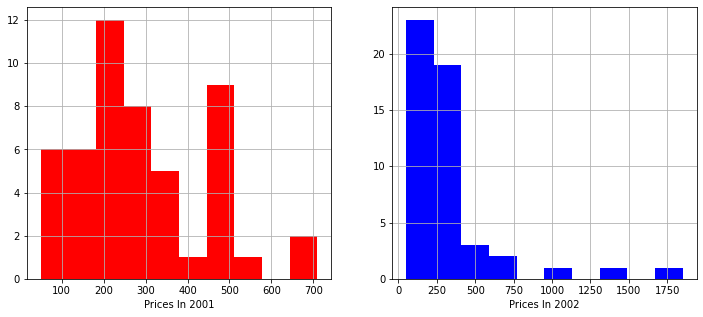

In [19]:
# Взглянем на распределения цен для 2-х годов
plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
plt.hist(price_2001, color = 'r')
plt.grid()
plt.xlabel('Prices In 2001')

plt.subplot(1,2,2)
plt.hist(price_2002, color = 'b')
plt.grid()
plt.xlabel('Prices In 2002');

In [21]:
# Взглянем на средние
print('Mean Price In 2001: %.4f ' %price_2001.mean())
print('Mean Price In 2002: %.4f' %price_2002.mean())

Mean Price In 2001: 288.9265 
Mean Price In 2002: 329.2571


Кажется, что цены изменились, так ли это?

### Интервальная оценка
Как всегда самый быстрый способ это начать с доверительного интервала

In [28]:
print('95 %% Confidence Interval (Prices In 2001 Group): [%.4f, %.4f]' %zconfint(price_2001))
print('95 %% Confidence Interval (Prices In 2002 Group): [%.4f, %.4f]' %zconfint(price_2002))

95 % Confidence Interval (Prices In 2001 Group): [245.1936, 332.6595]
95 % Confidence Interval (Prices In 2002 Group): [241.4379, 417.0763]


Неудивительно, доверительные интервалы пересекаются, следовательно, необходимо использовать критерии проверки гипотез

### Ранговый Критерий Манна-Уитни

В случае рангового критерия мы проверяем гипотезу о том, что вероятность того, что значение из первой выборки будет больше, чем значение из второй выборки, равна вероятности того, что значение из второй выборки будет больше, чем значение из первой выборки. Альтернатива — то, что это не так. Сформулируем гипотезы (другой вариант) и воспользуемся готовой имплементацией.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [29]:
stats.mannwhitneyu(price_2001, price_2002)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

Цены не изменились, критерий не отвергает нулевую гипотезу. Попробуем применить перестановочный критерий.

### Двухвыборочный Перестановочный Критерий (независимые выборки)
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

Нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.

Реализации нет, реализуем сами

In [62]:
# Расчет t - статистики для независимых выборок
def permutation_t_stat_ind(sample_1, sample_2):
    return sample_1.mean() - sample_2.mean()

Нужно научиться считать нулевое распределение. В случае справедливости нулевой гипотезы любое значение, встреченное, например, в первой выборке, мы могли бы с тем же успехом встретить и во второй выборке. То есть если нулевая гипотеза справедлива, то мы можем равновероятно получить любое разделение исходных данных на две подвыборки.

Для того чтобы получить нулевое распределение, нам нужно с вами построить все возможные комбинации, все возможные разбиения данных на подвыборки, то есть, получается, построить все сочетания.

In [63]:
# Функция генерирования индексов для разбиения данных на первую и вторую выборку случайным образом
def get_random_combinations(n1, n2, max_combinations):
    
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
        
    return [(index[:n1], index[n1:]) for index in indices]

In [64]:
def get_permutation_zero_distr_ind(sample_1, sample_2, max_combinations = None):
    # Объединим выборки в одну и рассчитаем необходимые параметры
    joined_sample = np.hstack((sample_1, sample_2))
    
    n_1 = len(sample_1)
    n_2 = len(sample_2)
    n = len(joined_sample)
    
    # Если нам задано ограничение на максимальное количество комбинаций, 
    # то сгенерируем индексы для разбиения данных на первую и вторую выборку случайным образом
    if max_combinations:
        indices = get_random_combinations(n_1, n_2, max_combinations)
        
    # Иначе явно перебираем все возможные комбинации 
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n_1)]
        
    # построим разделение нашей выборки на две по соответствующим индексам 
    # Далее рассчитаем нужную статистику, то есть разницу средних по полученным разбиениям
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    
    return distr

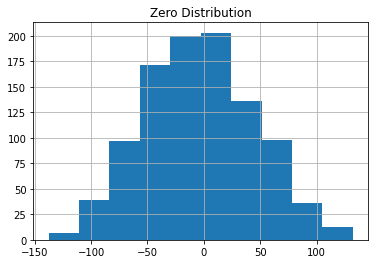

In [67]:
# Взглянем на нулевое распределение
plt.hist(get_permutation_zero_distr_ind(price_2001, price_2002, max_combinations = 1000))
plt.grid()
plt.title('Zero Distribution');

Выглядит как нормальное

In [69]:
# Получение p-value
def get_p_value_permutation_test_2sample_ind(sample_1, sample_2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError ('Alternative Not Recognized!!!')
        
    t_stat = round(permutation_t_stat_ind(sample_1, sample_2), 4)
    zero_distribution = get_permutation_zero_distr_ind(sample_1, sample_2, max_permutations)
    
    if alternative == 'two-sided':
        return t_stat, round(sum([1 if abs(x) >= abs(t_stat) else 0 for x in zero_distribution]) / len(zero_distribution), 4)
    
    if alternative == 'less':
        return t_stat, round(sum([1 if x <= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 4)

    if alternative == 'greater':
        return t_stat, round(sum([1 if x >= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 4)

In [72]:
# p-value для 10к перестановок
test_res_1 = get_p_value_permutation_test_2sample_ind(
    sample_1 = price_2001,
    sample_2 = price_2002,
    max_permutations = 10000,
    alternative = 'two-sided'
)
print(f'Statistics: {test_res_1[0]}, p-value: {test_res_1[1]}')

Statistics: -40.3306, p-value: 0.4471


In [1]:
# p-value для 50к перестановок
test_res_2 = get_p_value_permutation_test_2sample_ind(
    sample_1 = price_2001,
    sample_2 = price_2002,
    max_permutations = 50000,
    alternative = 'two-sided'
)
print(f'Statistics: {test_res_2[0]}, p-value: {test_res_2[1]}')

NameError: name 'get_p_value_permutation_test_2sample_ind' is not defined

Не один из критериев не позволяет нам отвергнуть нулевую гипотезу, следовательно, цены значимо не изменились, хотя по выборке кажется, что изменились. Поэтому всегда нужно проверять гипотезы при помощи статистических критериев